##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP Probabilistic Layers: Regression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this example we show how to fit regression models using TFP's "probabilistic layers."

### Dependencies & Prerequisites


In [0]:
#@title Install { display-mode: "form" }
TF_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TF_Installation == "Nightly":
  !pip install -q tf-nightly
  print("Installation of `tf-nightly` complete.")
elif TF_Installation == "Stable":
  !pip install -q --upgrade tensorflow
  print("Installation of `tensorflow` complete.")
elif TF_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [0]:
#@title Install { display-mode: "form" }
TFP_Installation = "Nightly" #@param ["Nightly", "Stable", "System"]

if TFP_Installation == "Nightly":
  !pip install -q tfp-nightly
  print("Installation of `tfp-nightly` complete.")
elif TFP_Installation == "Stable":
  !pip install -q --upgrade tensorflow-probability
  print("Installation of `tensorflow-probability` complete.")
elif TFP_Installation == "System":
  pass
else:
  raise ValueError("Selection Error: Please select a valid "
                   "installation option.")

In [0]:
#@title Import { display-mode: "form" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tf.enable_v2_behavior()
%matplotlib inline

tfd = tfp.distributions

## Motivation

Wouldn't it be great if we could use TFP to specify a probabilistic model then simply minimize the negative log-likelihood, i.e.,

In [0]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

Well not only is it possible, but this colab shows how! (In context of linear regression problems.)

In [0]:
#@title Synthesize dataset.
np.random.seed(43)
n = 150
w0 = 0.125
b0 = 5.
x_range = [-20, 60]
x_tst = np.linspace(*x_range).astype(np.float32)

if False:
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3*(0.25 + g**2.)

  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x + b0) + eps 
else:
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3*(0.25 + g**2.)

  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1 + np.sin(x)) + b0) + eps
  
  
x = x[..., tf.newaxis]            
x_tst = x_tst[..., tf.newaxis]    

### Case 1: No Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

0.134690284729
5.12559556961


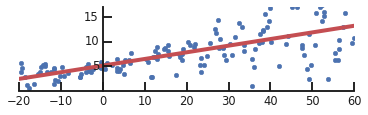

In [0]:
#@title Figure 1: No uncertainty.
w = np.squeeze(model.layers[-2].kernel.numpy())
b = np.squeeze(model.layers[-2].bias.numpy())

plt.figure(figsize=[6, 1.5])  # inches
#plt.figure(figsize=[8, 5])  # inches
plt.plot(x, y, 'b.', label='observed');
plt.plot(x_tst, yhat.mean(),'r', label='fit', linewidth=4);
plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)

plt.savefig('/tmp/fig1.png', bbox_inches='tight', dpi=300)

### Case 2: Aleatoric Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1 + 1),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.05 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.12943099  0.98516005]
[  5.20973301  10.20972252]


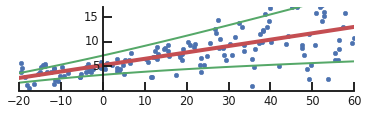

In [0]:
#@title Figure 2: Aleatoric Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

m = yhat.mean()
s = yhat.stddev()

plt.plot(x_tst, m, 'r', linewidth=4, label='fit');
plt.plot(x_tst, m + 2 * s, 'g', linewidth=2, label=r'$\mu+\sigma$');
plt.plot(x_tst, m - 2 * s, 'g', linewidth=2, label=r'$\mu-\sigma$');

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)

plt.savefig('/tmp/fig2.png', bbox_inches='tight', dpi=300)

### Case 3: Epistemic Uncertainty

In [0]:
#@title DenseVariational Layer
class DenseVariational(tf.keras.layers.Layer):

  def __init__(self,
               units,
               make_posterior_fn,
               make_prior_fn,
               num_training_samples=None,
               use_exact_kl=False,
               num_ensembles=1,
               activation=None,
               use_bias=True,
               activity_regularizer=None,
               **kwargs):
    if 'input_shape' not in kwargs and 'input_dim' in kwargs:
      kwargs['input_shape'] = (kwargs.pop('input_dim'),)

    super(DenseVariational, self).__init__(
        activity_regularizer=tf.keras.regularizers.get(activity_regularizer),
        **kwargs)
    self.units = int(units)
    
    self._make_posterior_fn = make_posterior_fn
    self._make_prior_fn = make_prior_fn
    self._kl_divergence_fn = _make_kl_divergence_penalty(
        use_exact_kl, weight=num_training_samples)

    self.activation = tf.keras.activations.get(activation)
    self.use_bias = use_bias
    self.supports_masking = False
    self.input_spec = tf.keras.layers.InputSpec(min_ndim=2)

  def build(self, input_shape):
    dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
    if not (dtype.is_floating or dtype.is_complex):
      raise TypeError('Unable to build `Dense` layer with non-floating point '
                      'dtype %s' % (dtype,))
    input_shape = tf.TensorShape(input_shape)
    last_dim = tf.compat.dimension_value(input_shape[-1])
    if last_dim is None:
      raise ValueError('The last dimension of the inputs to `Dense` '
                       'should be defined. Found `None`.')
    self.input_spec = tf.keras.layers.InputSpec(
        min_ndim=2, axes={-1: last_dim})
    num_params = (last_dim + 1 if self.use_bias else 0) * self.units
    self._posterior = self._make_posterior_fn(
        last_dim * self.units, self.units if self.use_bias else 0, dtype)
    self._prior = self._make_prior_fn(
        last_dim * self.units, self.units if self.use_bias else 0, dtype)
    self.built = True

  def call(self, inputs):
    dtype = tf.as_dtype(self.dtype or tf.keras.backend.floatx())
    inputs = tf.cast(inputs, dtype, name='inputs')

    q = self._posterior(inputs)
    r = self._prior(inputs)

    self.add_loss(self._kl_divergence_fn(q, r))  # FIXME: Divide by batch size?

    w = tf.convert_to_tensor(q)
    prev_units = self.input_spec.axes[-1]
    if self.use_bias:
      split_sizes = [prev_units * self.units, self.units]
      kernel, bias = tf.split(w, split_sizes, axis=-1)
    else:
      kernel, bias = w, None

    kernel = tf.reshape(kernel, shape=tf.concat([
        tf.shape(kernel)[:-1],
        [prev_units, self.units],
      ], axis=0))
    outputs = tf.matmul(inputs, kernel[0])  # FIXME

    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, bias[0])   # FIXME

    if self.activation is not None:
      return self.activation(outputs)  # pylint: disable=not-callable

    return outputs
  
  
def _make_kl_divergence_penalty(
    use_exact_kl=False,
    test_points_reduce_axis=(),  # `None` == "all"; () == "none".
    test_points_fn=tf.convert_to_tensor,
    weight=None):
  """Creates a callable computing `KL[a,b]` from `a`, a `tfp.distributions.Distribution`."""

  if use_exact_kl is None:
    kl_divergence_fn = tfp.distributions.kl_divergence
  else:
    def kl_divergence_fn(distribution_a, distribution_b):
      z = test_points_fn(distribution_a)
      return tf.reduce_mean(
          input_tensor=distribution_a.log_prob(z) - distribution_b.log_prob(z),
          axis=test_points_reduce_axis)

  # Closure over: kl_divergence_fn, weight.
  def _fn(distribution_a, distribution_b):
    """Closure that computes KLDiv as a function of `a` as in `KL[a, b]`."""
    with tf.name_scope('kldivergence_loss'):
      kl = kl_divergence_fn(distribution_a, distribution_b)
      if weight is not None:
        kl = tf.cast(weight, dtype=kl.dtype) * kl
      # Losses appended with the model.add_loss and are expected to be a single
      # scalar, unlike model.loss, which is expected to be the loss per sample.
      # Therefore, we reduce over all dimensions, regardless of the shape.
      # We take the sum because (apparently) Keras will add this to the *post*
      # `reduce_sum` (total) loss.
      # TODO(b/126259176): Add end-to-end Keras/TFP test to ensure the API's
      # align, particularly wrt how losses are aggregated (across batch
      # members).
      return tf.reduce_sum(input_tensor=kl, name='batch_total_kl_divergence')

  return _fn

In [0]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer([1, 2 * n], dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer([1, n], dtype=dtype),
      tfp.layers.DistributionLambda(
          lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1), 1)),
  ])

In [0]:
# Build model.
model = tf.keras.Sequential([
  DenseVariational(1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.14647654  5.0822401  -3.89232993 -0.37871635]
[ 0.21571356  5.19328022]


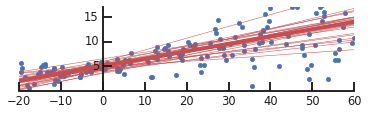

In [0]:
#@title Figure 3: Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.clf();
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 25:
    plt.plot(x_tst, m, 'r', label='fit', linewidth=0.5)
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='fit', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)

plt.savefig('/tmp/fig3.png', bbox_inches='tight', dpi=300)

### Case 4: Aleatoric & Epistemic Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  DenseVariational(1 + 1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False);

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
yhat = model(x_tst)
assert isinstance(yhat, tfd.Distribution)

[ 0.13766883  3.44315124  5.33326769  4.14301205 -3.50617266 -0.49605423
 -0.77583206 -0.1967552 ]
[ 0.12916879  3.10026217  4.9960804   4.37491941]


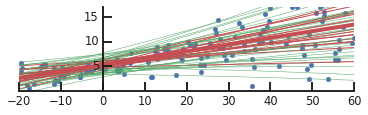

In [0]:
#@title Figure 4: Both Aleatoric & Epistemic Uncertainty
plt.figure(figsize=[6, 1.5])  # inches
plt.plot(x, y, 'b.', label='observed');

yhats = [model(x_tst) for _ in range(100)]
avgm = np.zeros_like(x_tst[..., 0])
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())
  if i < 15:
    plt.plot(x_tst, m, 'r', label='fit', linewidth=1.)
    plt.plot(x_tst, m + 2 * s, 'g', linewidth=0.5, label=r'$\mu+\sigma$');
    plt.plot(x_tst, m - 2 * s, 'g', linewidth=0.5, label=r'$\mu-\sigma$');
  avgm += m
plt.plot(x_tst, avgm/len(yhats), 'r', label='fit', linewidth=4)

plt.ylim(-0.,17);
plt.yticks(np.linspace(0, 15, 4)[1:]);
plt.xticks(np.linspace(*x_range, num=9));

ax=plt.gca();
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)

plt.savefig('/tmp/fig4.png', bbox_inches='tight', dpi=300)